In [295]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [296]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [297]:
df = pd.read_csv('Student_Performance.csv')

In [298]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [299]:
df.dtypes

Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

In [300]:
df.columns.tolist()

['Hours Studied',
 'Previous Scores',
 'Extracurricular Activities',
 'Sleep Hours',
 'Sample Question Papers Practiced',
 'Performance Index']

In [301]:
df.isnull().sum()
df.drop_duplicates(inplace=True)


<Axes: >

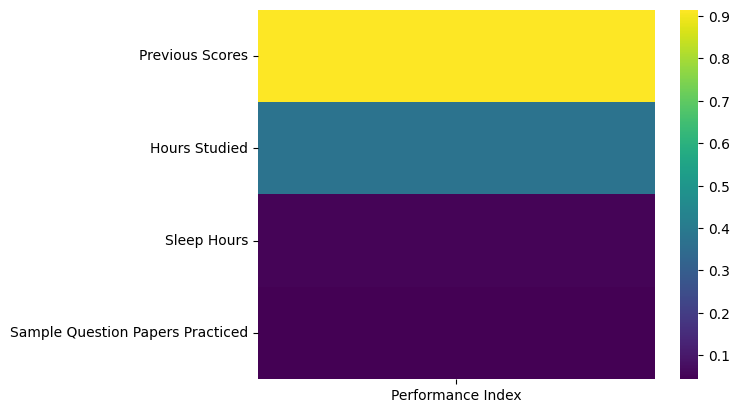

In [302]:
sns.heatmap(df.corr(numeric_only=True)['Performance Index'].to_frame().drop('Performance Index').sort_values('Performance Index',ascending=False),cmap=('viridis'))

In [303]:
oenhotencoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoder= oenhotencoder.fit(df[['Extracurricular Activities']])



In [304]:
X_train , X_temp , Y_train,Y_temp = train_test_split(df.drop(['Performance Index'],axis=1),df['Performance Index'],test_size=.3,shuffle=True)
X_val ,X_test , Y_val,Y_test = train_test_split(X_temp,Y_temp,test_size=.5,shuffle=True)

In [305]:
scaler = MinMaxScaler()
scaled = scaler.fit(X_train.drop('Extracurricular Activities',axis=1))

In [306]:
class CustomDataset(Dataset):
    def __init__(self,X,Y):
        
        numeric_features = scaled.transform(X.drop(['Extracurricular Activities'],axis=1))
        encoded = encoder.transform(X[['Extracurricular Activities']])
    
        self.X=torch.tensor(np.concatenate([numeric_features,encoded],axis=1),dtype=torch.float32)
        self.Y=torch.tensor(Y,dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index],self.Y[index]

In [307]:
train_dataset = CustomDataset(X_train,Y_train.values)
val_dataset = CustomDataset(X_val,Y_val.values)
test_dataset = CustomDataset(X_test,Y_test.values)

In [308]:
BATCH_SIZE = 32
EPOCHS=64
LR=5e-3

In [309]:
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [310]:
class MyModule(nn.Module):
    def __init__(self,input_size,num_classes=1):
        super().__init__()
        
        self.network=nn.Sequential(
            nn.Linear(input_size,num_classes)
        )
        
    def forward(self,x):
        return self.network(x)

In [311]:
x,y=train_dataset[0]
x.shape

torch.Size([6])

In [312]:
model = MyModule(x.shape[0]).to(device)

In [313]:
optimizer = Adam(model.parameters(),lr=LR)
criterion = nn.MSELoss()

In [318]:
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
total_train_loss = []
total_val_loss = []
total_train_r2 = []
total_val_r2 =[]

best_val_r2 = 0

for epoch in range(EPOCHS):
    all_train_preds = []
    epoch_train_loss=0
    all_train_labels=[]
    model.train()
    
    for inputs,labels in tqdm(train_dataloader,desc='Training',leave=False):
        inputs,labels = inputs.to(device),labels.view(-1,1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss +=loss.item()*inputs.size(0)
        
        all_train_preds.append(outputs.detach().cpu())
        all_train_labels.append(labels.cpu())
        
    epoch_train_loss /= len(train_dataset)
    all_train_preds = torch.cat(all_train_preds).numpy()
    all_train_labels = torch.cat(all_train_labels).numpy()
    epoch_train_r2 =r2_score(all_train_labels,all_train_preds)
    
    total_train_loss.append(epoch_train_loss)
    total_train_r2.append(epoch_train_r2)
    
    model.eval()
    epoch_val_loss = 0
    all_val_preds=[]
    all_val_labels=[]
    
    with torch.no_grad():
        for inputs,labels in val_dataloader:
            inputs,labels = inputs.to(device),labels.view(-1,1).to(device)
            outputs = model(inputs)
            loss=criterion(outputs,labels)
            epoch_val_loss += loss.item() * inputs.size(0)
            
            all_val_labels.append(labels.cpu())
            all_val_preds.append(outputs.cpu())
            
    epoch_val_loss /= len(val_dataset)
    all_val_preds= torch.cat(all_val_preds).numpy()
    all_val_labels = torch.cat(all_val_labels).numpy()
    epoch_val_r2 = r2_score(all_val_labels,all_val_preds)
        
    total_val_loss.append(epoch_val_loss)
    total_val_r2.append(epoch_val_r2)
        
    if epoch % 7 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Train MSE: {epoch_train_loss:.3f}, Train R^2: {epoch_train_r2:.3f}')
        print(f'Epoch {epoch+1}/{EPOCHS}, Val MSE: {epoch_val_loss:.3f}, Val R^2: {epoch_val_r2:.3f}')
    
    if epoch_val_r2 > best_val_r2:
        best_val_r2 = epoch_val_r2
        torch.save(model.state_dict(), 'best_model.pth')
        if epoch % 7 == 0:
            print(f"Saved best model with Val R^2: {epoch_val_r2:.3f}")
    

In [326]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.view(-1,1).to(device)
        outputs = model(inputs)
        
        all_test_preds.append(outputs.cpu())
        all_test_labels.append(labels.cpu())


all_test_preds = torch.cat(all_test_preds).numpy()
all_test_labels = torch.cat(all_test_labels).numpy()


test_mse = mean_squared_error(all_test_labels, all_test_preds)
test_r2 = r2_score(all_test_labels, all_test_preds)

print(f"Test MSE: {test_mse:.3f}, Test R^2: {test_r2:.3f}")

Test MSE: 3.986, Test R^2: 0.989
